### Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from neuropy.plotting import Fig
import pandas as pd
from tqdm import tqdm
from scipy import stats
import subjects
from neuropy.utils.signal_process import WaveletSg

sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    + subjects.nsd.ratJday2
    + subjects.nsd.ratKday2
    + subjects.nsd.ratNday2
    + subjects.nsd.ratSday2
    + subjects.nsd.ratRday1
    + subjects.nsd.ratUday2
    + subjects.nsd.ratVday1
)

rpl_channels = [39, 63, 111, 95, 49, 100, 85, 63, 63, 36, 188, 16, 99, 86]


### Ripple power spectrum comaprison 1st vs 5th vs 8th hour
- To see if ripple lfp timeseries changes PSD during sleep deprivation and compare it to NSD
- Method: Ripple traces are concatenated in their corresponding hour and then a PSD is calculated
- Results: Compared to 1st hour, ripple band in 5th and 8th hour show a little shift towards slower frequencies (maybe the start cutoff for ripple band is only changing)

In [ ]:
import scipy.signal as sg
from neuropy.core import Epoch

psd_rpl_df = pd.DataFrame()
norm_psd = lambda p: p / np.sqrt(p)

for sub, sess in enumerate(tqdm(sessions)):
    pre = sess.paradigm["pre"]
    maze = sess.paradigm["maze"]
    post = sess.paradigm["post"]
    # rpl_chan = sess.ripple.metadata["channels"][2]
    if sess.tag == "sd":
        post = post.flatten()
        post_epochs = Epoch.from_array(
            [post[0], post[0] + 5 * 3600], [post[0] + 5 * 3600, post[1]], ["sd", "rs"]
        )
        all_epochs = pre + maze + post_epochs
    else:
        all_epochs = pre + maze + post

    psd = []
    for e in all_epochs.itertuples():
        signal = sess.eegfile.get_signal(rpl_channels[sub], e.start, e.stop)
        rpl_t = sess.ripple.time_slice(e.start, e.stop).as_array()
        rpl_frames = [np.arange(int(e[0] * 1250), int(e[1] * 1250)) for e in rpl_t]
        rpl_frames = np.concatenate(rpl_frames) - int(e.start * 1250)
        rpl_frames = rpl_frames[rpl_frames < signal.n_frames]
        f, psd = sg.welch(
            signal.traces[0][rpl_frames], fs=1250, nperseg=125, noverlap=62
        )
        psd_rpl_df = psd_rpl_df.append(
            pd.DataFrame(
                {"freq": f, "psd": psd, "Epoch": e.label, "sub": sub, "grp": sess.tag}
            ),
            ignore_index=True,
        )

subjects.GroupData().save(psd_rpl_df, "ripple_psd")


In [ ]:
# %matplotlib widget
import seaborn as sns
from neuropy.plotting import Fig

figure = Fig()
fig, gs = figure.draw(grid=(5, 4))

for i, grp in enumerate(["sd", "nsd"]):
    df = psd_rpl_df[psd_rpl_df["grp"] == grp]
    ax = plt.subplot(gs[i])
    sns.lineplot(
        data=df,
        x="freq",
        y="psd",
        hue="hour",
        ci=None,
        ax=ax,
        legend=None,
    )
    ax.set_yscale("log")
    # ax.set_xscale('log')
    ax.set_xlim([60, 350])
    ax.set_ylim([5, 100])
    ax.set_xlabel("Frequency (Hz)")
    ax.set_ylabel("Psd")
    # ax.set_xticks([60,100,200,300],['',100,200,''])
    # ax.set_xticks([100,200],rotation=45)

figure.savefig(subjects.figpath_sd / "ripple_psd_various_epochs")


### Ripple power (z-score) compared NSD vs SD

In [10]:
sessions = subjects.nsd.ripple_sess + subjects.sd.ripple_sess


In [13]:
zsc_df = []
for sub, sess in enumerate(sessions):
    pre = sess.paradigm["pre"].flatten()
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()

    zts = np.array([0, 2.5, 5, 7.5])
    post_windows = zts * 3600 + post[0]
    # post_windows[-1] = np.min([post[1], post_windows[-1]])
    post_epochs = np.vstack([post_windows[:-1], post_windows[1:]]).T
    post_labels = [f"{zts[_]}-{zts[_+1]}" for _ in range(len(zts) - 1)]

    # epochs = np.vstack([pre, maze, post_epochs])
    # epochs_labels = ["pre", "maze"]
    # epochs_labels.extend(post_labels)

    epochs = post_epochs
    epochs_labels = post_labels

    for i, (w, label) in enumerate(zip(epochs, epochs_labels)):
        rpl_df = sess.ripple.time_slice(w[0], w[1]).to_dataframe()
        # rpl_df = rpl_df[rpl_df['peak_frequency']<240]
        starts = rpl_df.start.values
        zscores = rpl_df.peak_power.values

        zsc_df.append(
            pd.DataFrame(dict(zscore=zscores, t=label, sub=sub, grp=sess.tag))
        )

zsc_df = pd.concat(zsc_df, ignore_index=True)
# zsc_df = zsc_df[zsc_df.f<240].reset_index(drop=True) # takes care of some boundary effects
subjects.GroupData().save(zsc_df, "ripple_zscore")


ripple_zscore saved


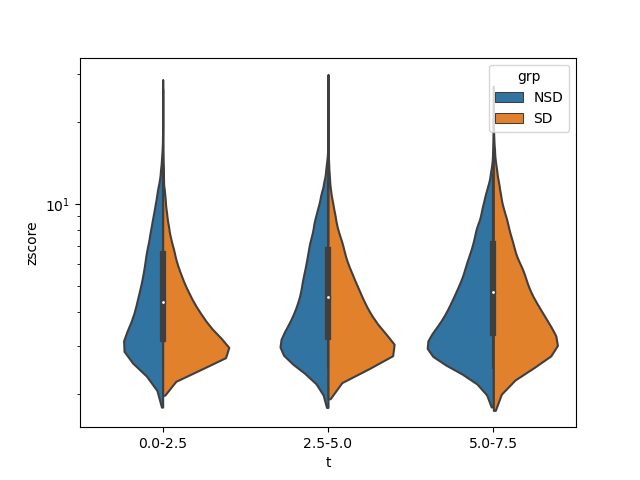

In [21]:
import seaborn as sns
_,ax = plt.subplots()
# df = zsc_df[zsc_df['grp']=='SD']
# sns.boxplot(data=zsc_df,x='t',y='zscore',hue='grp',showfliers=False)
sns.violinplot(data=zsc_df,x='t',y='zscore',hue='grp',split=True)
ax.set_yscale('log')

### Peri SWR spectrogram at selected ZTs for POST
- Basically average wavelet spectrogram across all ripples
- For SD sessions, I did not find any interesting dynamics other than an additional bump in the 15-30 Hz for Zt1, Zt3 and Zt5. Probably similar to what has been reported in Oliva2018 (Origin of gamma frequency power during hippocampal swrs).
- Did not do this analysis for NSD sessions.

In [ ]:
sessions = (
    subjects.sd.ratJday1
    + subjects.sd.ratKday1
    + subjects.sd.ratNday1
    + subjects.sd.ratSday3
    + subjects.sd.ratRday2
    + subjects.sd.ratUday4
    + subjects.sd.ratVday2
    # + subjects.nsd.ratJday2
    # + subjects.nsd.ratKday2
    # subjects.nsd.ratNday2
    # + subjects.nsd.ratSday2
    # + subjects.nsd.ratRday1
    # + subjects.nsd.ratUday2
    # + subjects.nsd.ratVday1
)
rpl_channels = [39, 63, 111, 95, 49, 100, 85, 63, 63, 36, 188, 16, 99, 86]
# rpl_channels=[100]


In [ ]:
from neuropy.utils.signal_process import hilbert_ampltiude_stat
from neuropy.core import Signal

spect = []
for sub, sess in enumerate(sessions):
    maze = sess.paradigm["maze"].flatten()
    post = sess.paradigm["post"].flatten()
    # rpl_chan = sess.ripple.metadata["channels"][2]

    t_starts = np.arange(0, 5, 2) * 3600 + post[0]

    freqs = np.geomspace(4, 350, 200)
    for t in t_starts:
        signal = sess.eegfile.get_signal(rpl_channels[sub], t, t + 3601)
        rpl_df = sess.ripple.time_slice(t, t + 3600).to_dataframe()
        peakframe = (rpl_df["peaktime"].values * 1250).astype("int")

        rpl_frames = [np.arange(p - 250, p + 250) for p in peakframe]
        rpl_frames = np.concatenate(rpl_frames) - int(t * 1250)
        rpl_frames = rpl_frames[rpl_frames < signal.n_frames]
        new_sig = Signal(
            signal.traces[0][rpl_frames].reshape(1, -1), sampling_rate=1250
        )
        wvlt = WaveletSg(
            signal=new_sig,
            freqs=freqs,
            ncycles=10,
        )
        # wvlt_mean = np.reshape(wvlt.traces, (len(freqs), len(peakframe), -1)).mean(
        #     axis=1
        # )
        wvlt_median = np.median(
            np.reshape(wvlt.traces, (len(freqs), len(peakframe), -1)), axis=1
        )
        spect.append(wvlt_median)


In [ ]:
from neuropy.plotting import Fig
from scipy.ndimage import gaussian_filter
from matplotlib.colors import LogNorm

figure = Fig()
fig, gs = figure.draw(grid=(5, 3))

for i in range(3):
    s = np.dstack(spect[i::3]).mean(axis=-1)
    # s = gaussian_filter(s,sigma=2)
    ax = plt.subplot(gs[i])
    ax.imshow(
        # np.linspace(-200, 200, 500),
        # freqs,
        stats.zscore(s, axis=1),
        # s,
        # extent=[-200,200],
        cmap="jet",
        # shading="gouraud",
        # vmax= 5,
        # norm=LogNorm(),
        interpolation="sinc",
        origin="lower",
        aspect="auto",
    )
    # ax.set_yscale('log')
    ax.set_yticks(np.arange(200)[::30], freqs[::30].round().astype("int"))
    ax.set_xticks([125, 250, 375], [-100, 0, 100])
    # ax.plot(np.median(s,axis=1))
# plt.yscale('log')

figure.savefig(subjects.figpath_sd / "ripple_peri_spectrogram_SD")
